In [47]:
import stlearn as st
import multimodal_cci as mmcci

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.int = np.int32
np.float = np.float32

### Load in Visium

In [52]:
data_dir = "/QRISdata/Q1851/Andrew_C/Other_Project/QIMR_Workshop/data/skin_data"

visium = sc.read_h5ad(f"{data_dir}/visium.h5ad")

## Run Visium stLearn CCI

In [49]:
visium.var_names_make_unique()

# Basic normalisation #
st.pp.filter_genes(visium, min_cells=3)
st.pp.normalize_total(visium) # NOTE: no log1p

Normalization step is finished in adata.X


In [50]:
card_path = f"{data_dir}/../../visium_decon.csv"

spot_mixtures = pd.read_csv(card_path, index_col=0)
spot_mixtures.head()

,KC_Cornified,KC_Differentiating,Imm_CD8+ T cell,KC_stem/hair/stress,Imm_Treg,Imm_pDC,Imm_Tcell,Imm_NK,Imm_Fibroblast,Imm_DC,KC_Basal,Melanocytes,Imm_Endothelial cell,KC_Granular,Imm_Macrophage,Imm_Bcells,Pericytes,Imm_Mast Cells,Imm_mRegDC,Imm_LC
AACACGTGCATCGCAC-1,0.000174,0.000097,0.000027,0.000132,0.000050,0.000004,0.000142,0.000169,0.905402,0.000141,0.000023,0.000767,0.003335,0.000004,0.005032,0.000003,0.000280,0.079345,0.004859,0.000013
AACAGGAAGAGCATAG-1,0.000426,0.000025,0.000029,0.000592,0.000020,0.000063,0.000096,0.000149,0.938201,0.000091,0.000021,0.000563,0.000149,0.000003,0.035068,0.000246,0.000063,0.020485,0.003585,0.000126
AACATCTAATGACCGG-1,0.000477,0.001880,0.000343,0.000126,0.000646,0.000048,0.000290,0.000203,0.880508,0.000104,0.000075,0.006640,0.005725,0.000053,0.100708,0.000282,0.000172,0.000433,0.001279,0.000007
AACATGCGCAAGTGAG-1,0.028730,0.151483,0.000510,0.103867,0.000400,0.001234,0.001490,0.001269,0.584374,0.007005,0.014522,0.010340,0.044565,0.004491,0.010533,0.000453,0.001305,0.025258,0.002427,0.005744
AACCAGAATCAGACGT-1,0.073579,0.729156,0.000659,0.007295,0.000668,0.000737,0.000667,0.001071,0.028985,0.002153,0.109877,0.017037,0.015493,0.000344,0.001585,0.000179,0.005739,0.000578,0.002308,0.001892


In [51]:
spot_mixtures['predicted_cell_type'] = spot_mixtures.idxmax(axis=1) # Get the cell type with the highest proportion
labels = spot_mixtures.loc[:,'predicted_cell_type'].values.astype(str) # Get the cell type labels
spot_mixtures = spot_mixtures.drop(['predicted_cell_type'], axis=1) # Drop the predicted cell type column

# Subset the visium to only include spots in the spot mixtures
visium = visium[spot_mixtures.index.values]

visium.write_h5ad(f"{data_dir}/visium.h5ad")

In [5]:
spot_mixtures['predicted_cell_type'] = spot_mixtures.idxmax(axis=1) # Get the cell type with the highest proportion
labels = spot_mixtures.loc[:,'predicted_cell_type'].values.astype(str) # Get the cell type labels
spot_mixtures = spot_mixtures.drop(['predicted_cell_type'], axis=1) # Drop the predicted cell type column

# Subset the visium to only include spots in the spot mixtures
visium = visium[spot_mixtures.index.values]

print('Spot mixture order correct?: ',
    np.all(spot_mixtures.index.values==visium.obs_names.values)) # Check is in correct order

# NOTE: using the same key in data.obs & data.uns
visium.obs['cell_type'] = labels # Adding the dominant cell type labels per spot
visium.obs['cell_type'] = visium.obs['cell_type'].astype('category')
visium.uns['cell_type'] = spot_mixtures # Adding the cell type scores

Spot mixture order correct?:  True


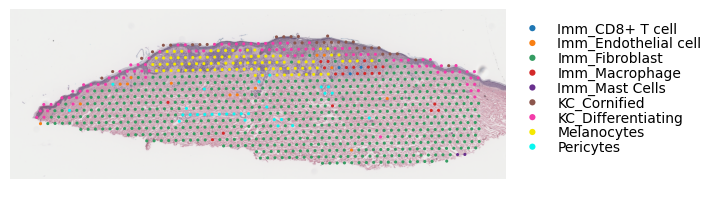

In [6]:
st.pl.cluster_plot(visium, use_label='cell_type')

In [7]:
# Loading the LR databases available within stlearn (from NATMI)
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')
print(len(lrs))

2293


In [8]:
# Running the analysis #
st.tl.cci.run(visium, lrs,
                min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                distance=None, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                n_pairs=10000, # Number of random pairs to generate; low as example, recommend ~10,000
                n_cpus=15, # Number of CPUs for parallel. If None, detects & use all available.
                )

Calculating neighbours...
0 spots with no neighbours, 6 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].


Altogether 1283 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████ [ time left: 00:00 ]  


Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].


In [9]:
lr_info = visium.uns['lr_summary'] # A dataframe detailing the LR pairs ranked by number of significant spots.
print('\n', lr_info)

st.tl.cci.adj_pvals(visium, correct_axis='spot',
                pval_adj_cutoff=0.05, adj_method='fdr_bh')


              n_spots  n_spots_sig  n_spots_sig_pval
COL1A1_CD44      916          669               844
VIM_CD44         915          633               808
COL1A2_CD44      916          625               814
COL1A1_DDR2      815          541               696
COL3A1_DDR2      811          486               681
...              ...          ...               ...
CD70_CD27         28            0                11
IL1B_IL1R1        37            0                18
IL1RN_IL1R2      147            0                34
IL16_KCNJ10       37            0                17
ZP3_MERTK         32            0                 8

[1283 rows x 3 columns]
Updated adata.uns[lr_summary]
Updated adata.obsm[lr_scores]
Updated adata.obsm[lr_sig_scores]
Updated adata.obsm[p_vals]
Updated adata.obsm[p_adjs]
Updated adata.obsm[-log10(p_adjs)]


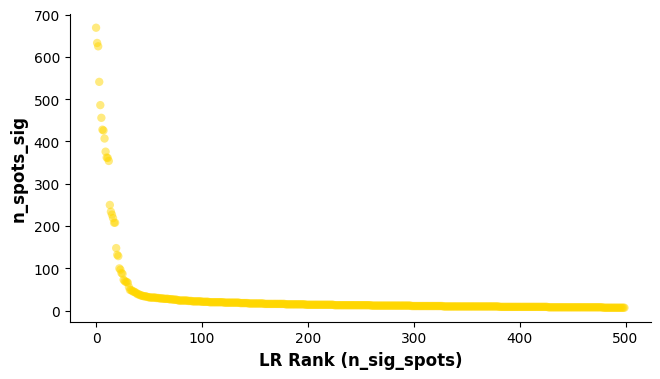

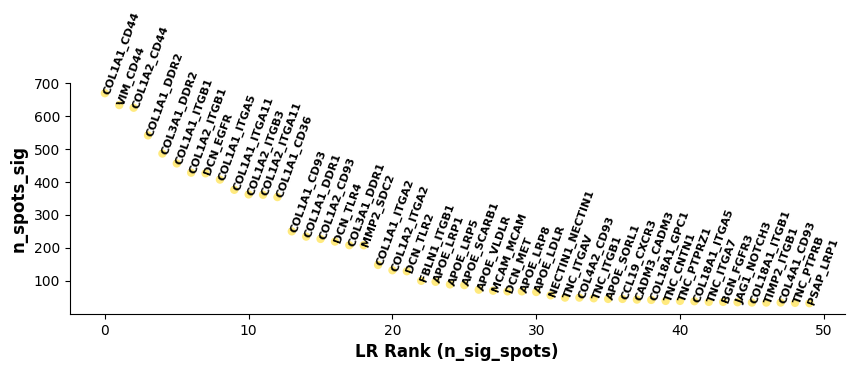

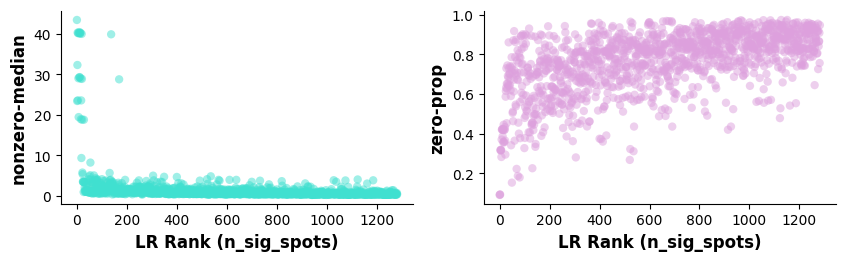

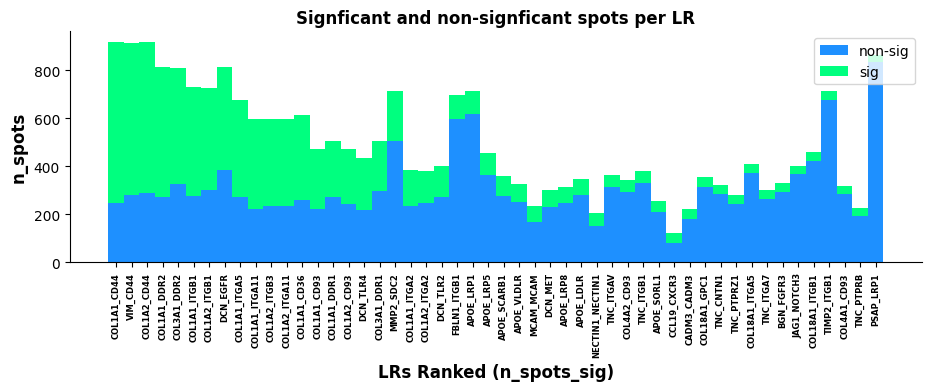

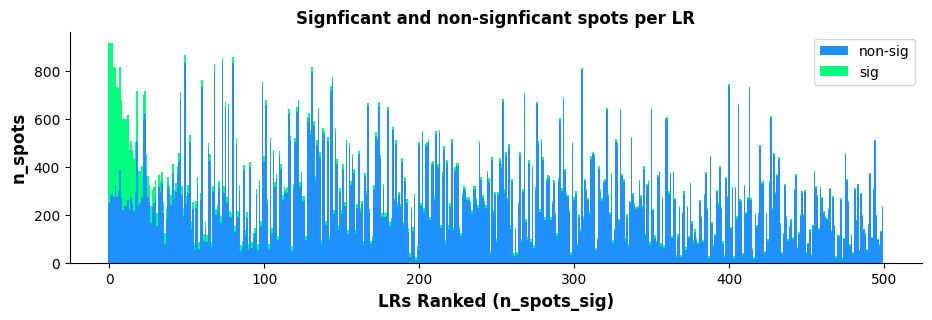

In [10]:
# Showing the rankings of the LR from a global and local perspective.
# Ranking based on number of significant hotspots.
st.pl.lr_summary(visium, n_top=500)
st.pl.lr_summary(visium, n_top=50, figsize=(10,3))

st.pl.lr_diagnostics(visium, figsize=(10,2.5))

st.pl.lr_n_spots(visium, n_top=50, figsize=(11, 3),
                    max_text=100)
st.pl.lr_n_spots(visium, n_top=500, figsize=(11, 3),
                    max_text=100)

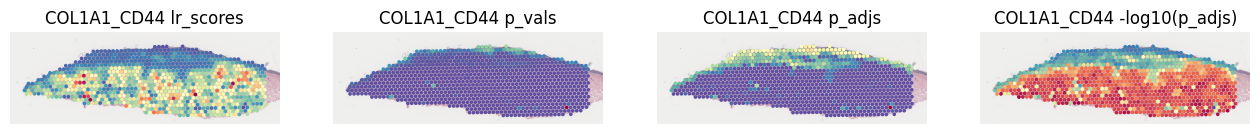

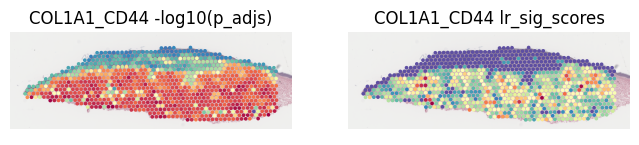

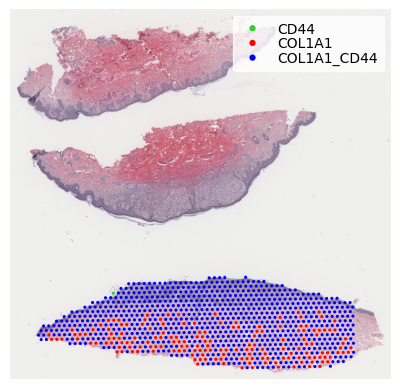

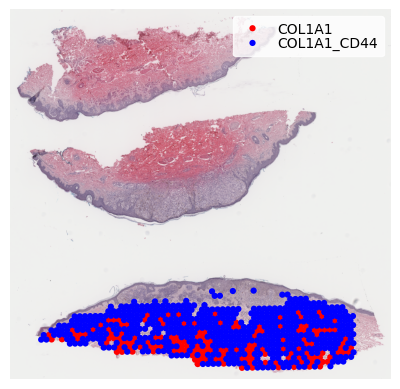

In [11]:
best_lr = visium.uns['lr_summary'].index.values[0] # Just choosing one of the top from lr_summary

stats = ['lr_scores', 'p_vals', 'p_adjs', '-log10(p_adjs)']
fig, axes = plt.subplots(ncols=len(stats), figsize=(16,6))
for i, stat in enumerate(stats):
    st.pl.lr_result_plot(visium, use_result=stat, use_lr=best_lr, show_color_bar=False, ax=axes[i])
    axes[i].set_title(f'{best_lr} {stat}')
    
fig, axes = plt.subplots(ncols=2, figsize=(8,6))
st.pl.lr_result_plot(visium, use_result='-log10(p_adjs)', use_lr=best_lr, show_color_bar=False, ax=axes[0])
st.pl.lr_result_plot(visium, use_result='lr_sig_scores', use_lr=best_lr, show_color_bar=False, ax=axes[1])
axes[0].set_title(f'{best_lr} -log10(p_adjs)')
axes[1].set_title(f'{best_lr} lr_sig_scores')

st.pl.lr_plot(visium, best_lr, inner_size_prop=0.1, outer_mode='binary', pt_scale=5,
            use_label=None, show_image=True,
            sig_spots=False)

st.pl.lr_plot(visium, best_lr, outer_size_prop=1, outer_mode='binary', pt_scale=20,
            use_label=None, show_image=True,
            sig_spots=True)

Getting cached neighbourhood information...
Getting information for CCI counting...


Counting celltype-celltype interactions per LR and permutating 100 times.:   0%|           [ time left: ? ]

Counting celltype-celltype interactions per LR and permutating 100 times.: 100%|██████████ [ time left: 00:00 ]   


Significant counts of cci_rank interactions for all LR pairs in data.uns[lr_cci_cell_type]
Significant counts of cci_rank interactions for each LR pair stored in dictionary data.uns[per_lr_cci_cell_type]


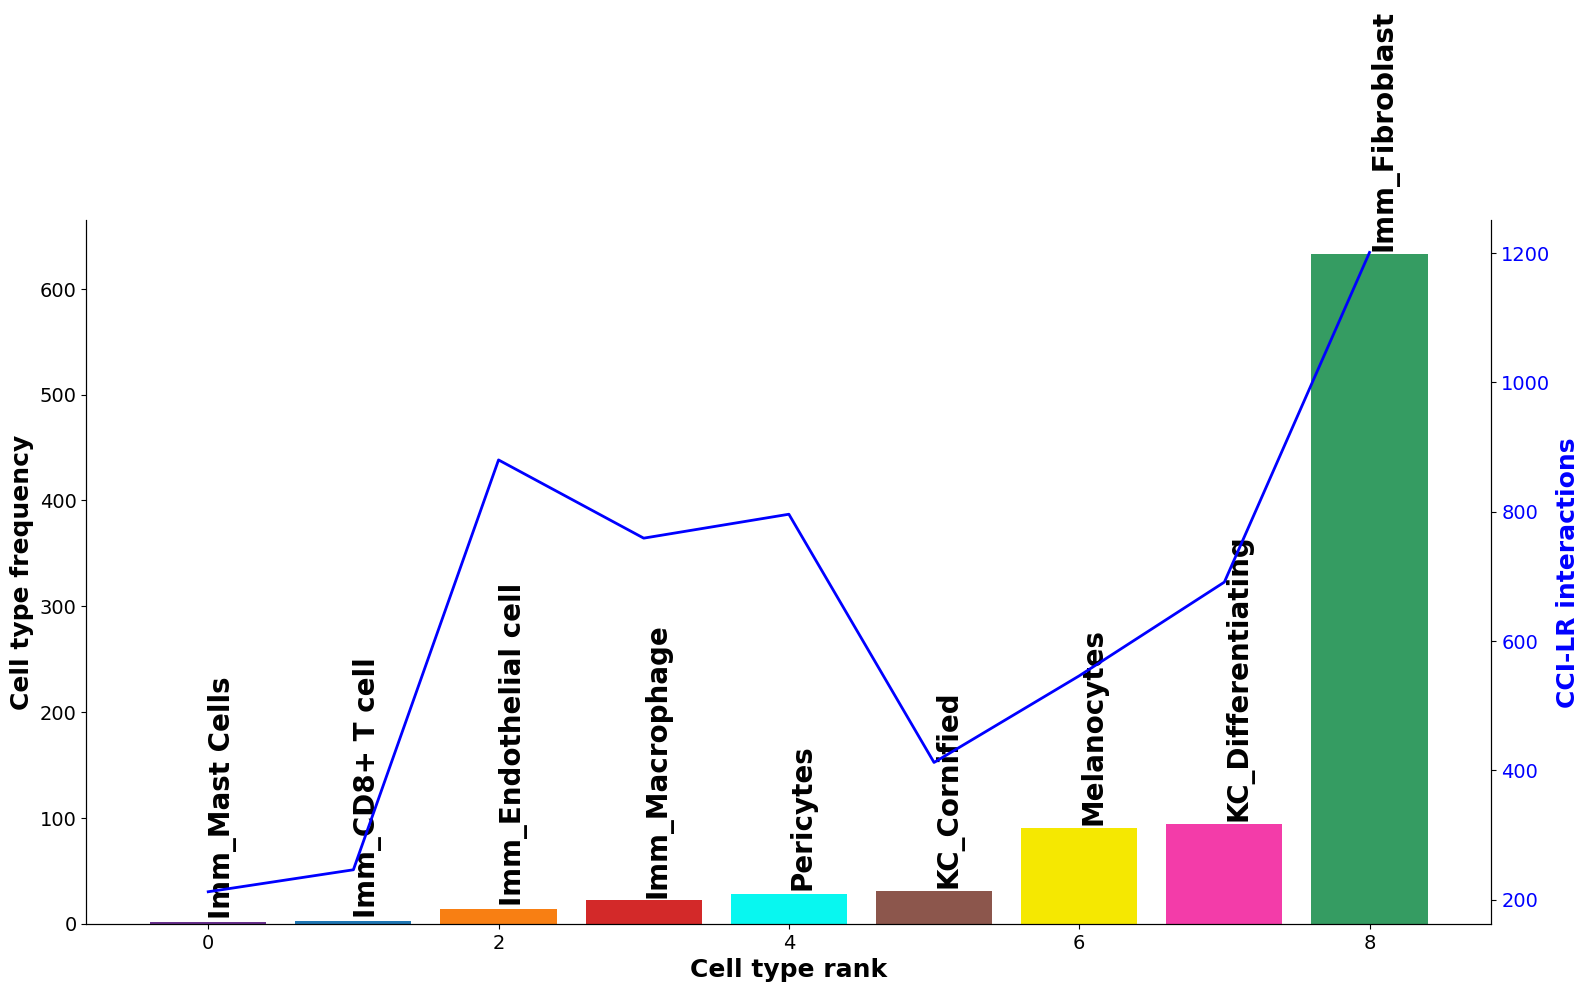

In [12]:
# Running the counting of co-occurence of cell types and LR expression hotspots #
st.tl.cci.run_cci(visium, 'cell_type', # Spot cell information either in data.obs or data.uns
                min_spots=3, # Minimum number of spots for LR to be tested.
                spot_mixtures=True, # If True will use the label transfer scores,
                                    # so spots can have multiple cell types if score>cell_prop_cutoff
                cell_prop_cutoff=0.2, # Spot considered to have cell type if score>0.2
                sig_spots=True, # Only consider neighbourhoods of spots which had significant LR scores.
                n_perms=100, # Permutations of cell information to get background, recommend ~1000,
                n_cpus=15 # Number of CPUs for parallel. If None, detects & use all available.
                )

st.pl.cci_check(visium, 'cell_type')

In [32]:
# make all columns float32
visium.uns['lrfeatures'] = visium.uns['lrfeatures'].astype(np.float32)

visium.write_h5ad(f"{data_dir}/visium_stlearn.h5ad")

## Analyse with MMCCI

In [53]:
visium = mmcci.tl.read_stLearn(f"{data_dir}/visium_stlearn.h5ad", return_adata=True)

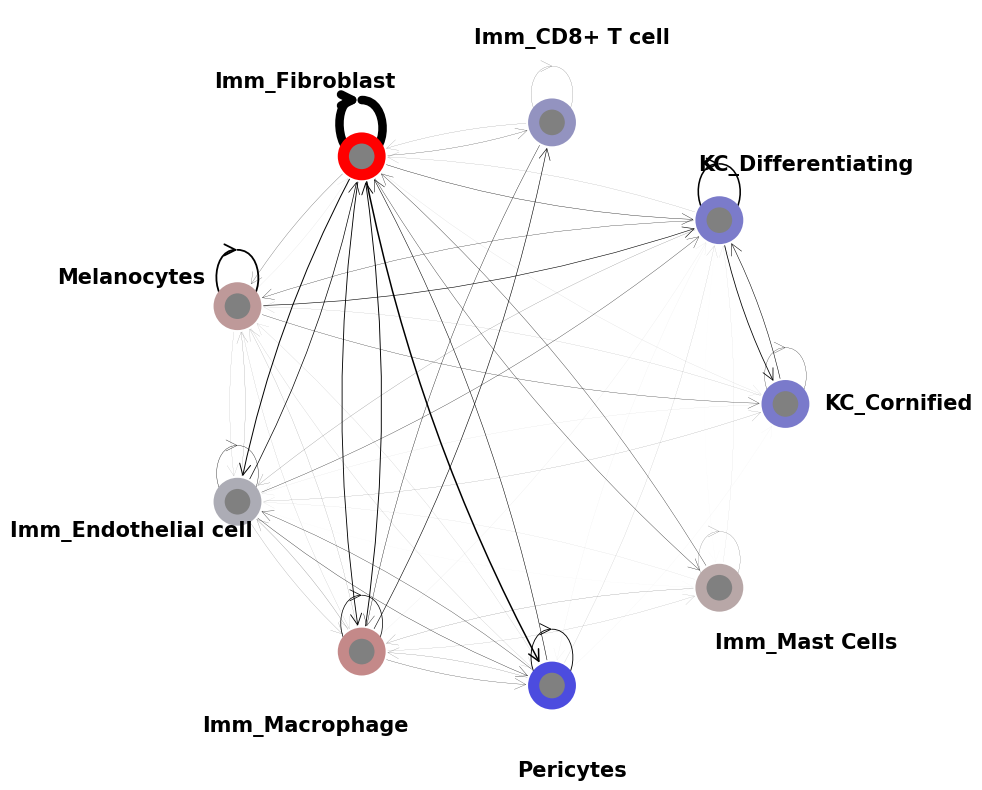

In [57]:
visium['lr_scores'] = mmcci.it.remove_insignificant(visium['lr_scores'], visium['lr_pvals'])
overall = mmcci.it.calculate_overall_interactions(visium['lr_scores'])
mmcci.plt.network_plot(overall)

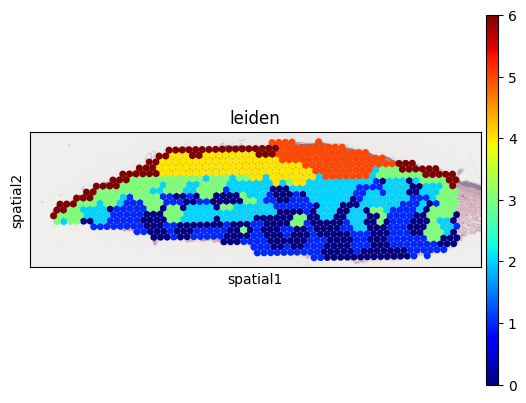

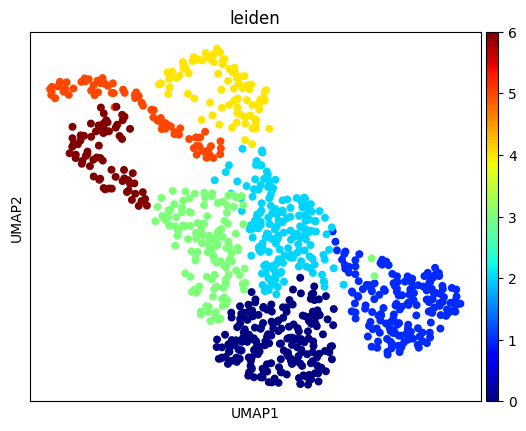

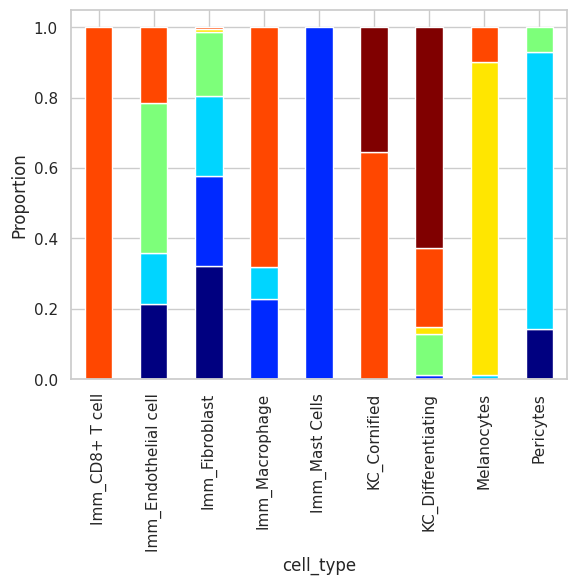

In [61]:
mmcci.an.lr_interaction_clustering(visium['adata'], clustering="leiden")

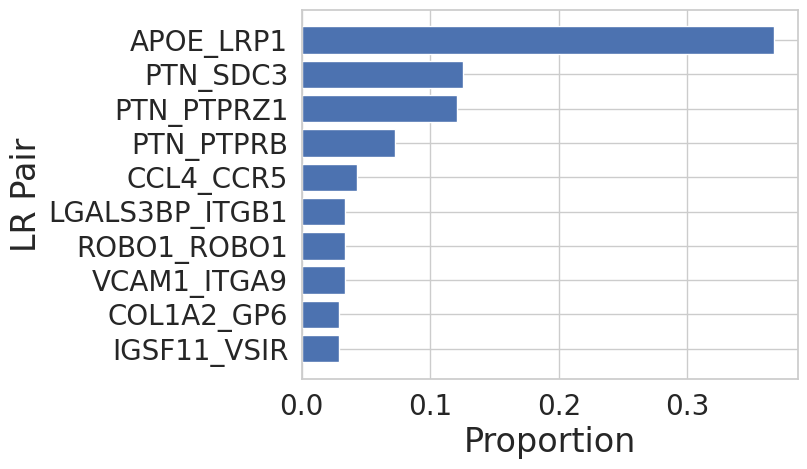

In [67]:
mmcci.plt.lrs_per_celltype(visium['lr_scores'], sender="Imm_Fibroblast", receiver="Melanocytes", n=10)

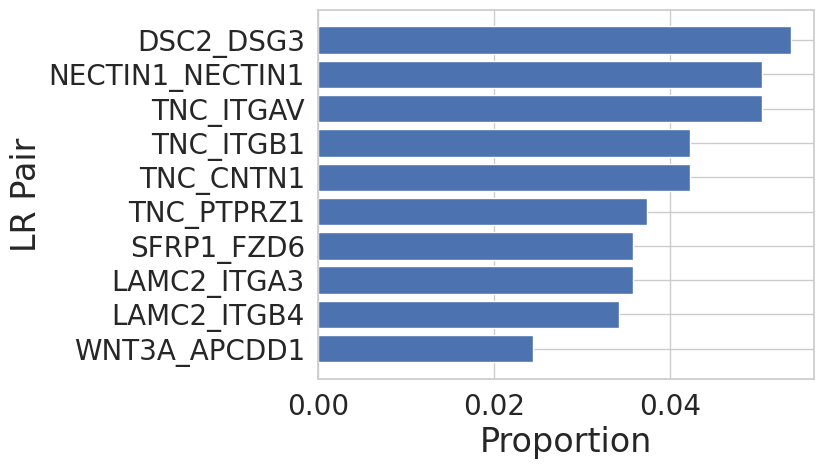

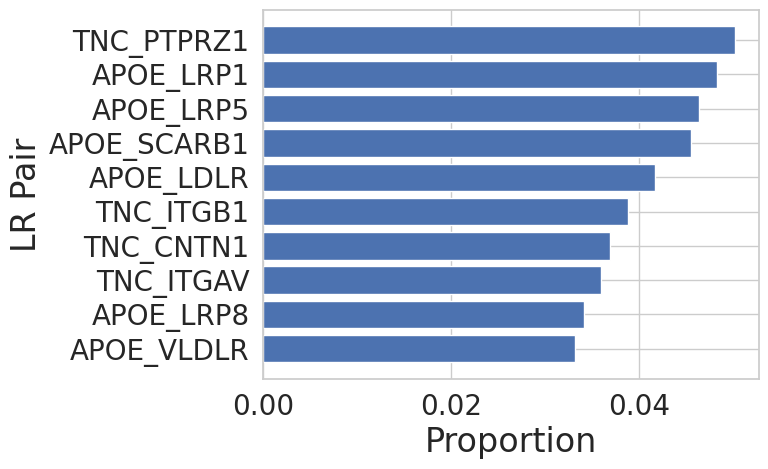

In [68]:
mmcci.plt.lrs_per_celltype(visium['lr_scores'], sender="KC_Differentiating", receiver="Melanocytes", n=10)
mmcci.plt.lrs_per_celltype(visium['lr_scores'], sender="Melanocytes", receiver="KC_Differentiating", n=10)

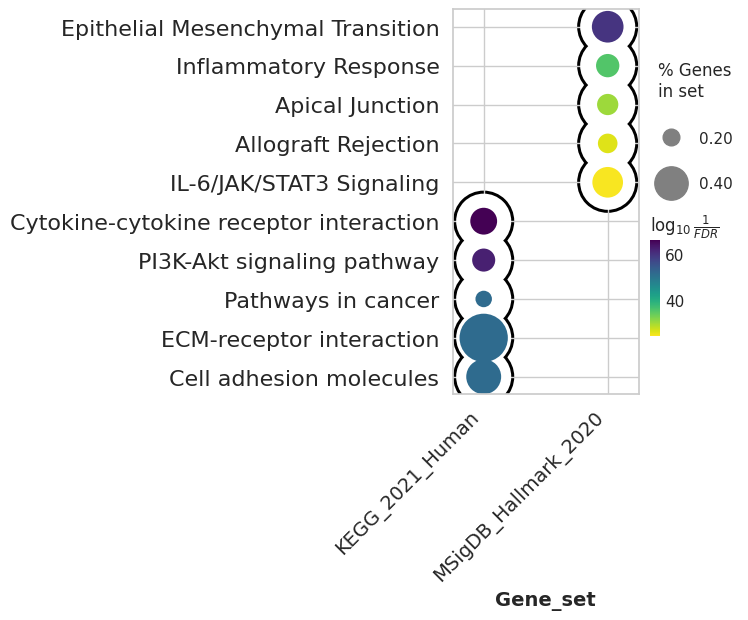

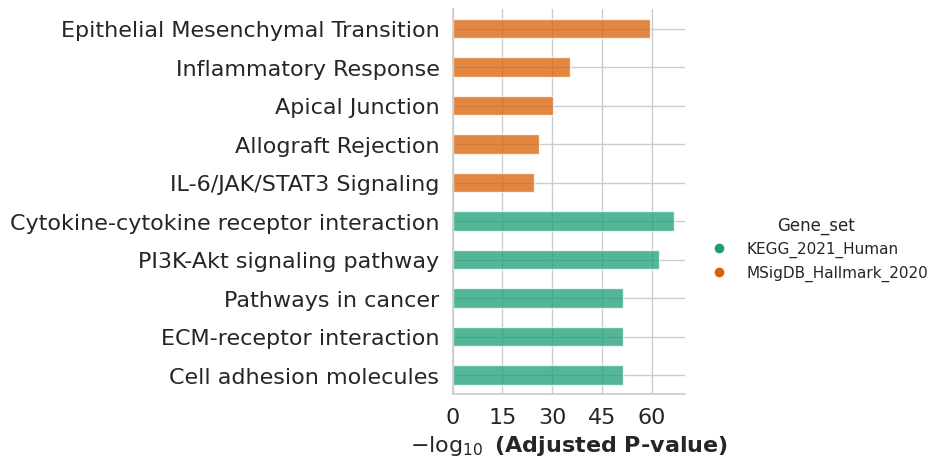

In [70]:
results = mmcci.an.run_gsea(visium['lr_scores'], gene_sets=["KEGG_2021_Human", "MSigDB_Hallmark_2020"], show_plots=True)

In [76]:
results["Term"][10:30]

10                               Rap1 signaling pathway
11                                              Malaria
12                               MAPK signaling pathway
13                                        Breast cancer
14                                Ras signaling pathway
15                     Regulation of actin cytoskeleton
16                           TGF-beta signaling pathway
17                                       Gastric cancer
18                           Hematopoietic cell lineage
19    Signaling pathways regulating pluripotency of ...
20                              Hippo signaling pathway
21                  Complement and coagulation cascades
22                          Hypertrophic cardiomyopathy
23                                Wnt signaling pathway
24                               Dilated cardiomyopathy
25    AGE-RAGE signaling pathway in diabetic complic...
26                            Calcium signaling pathway
27                                           Amo

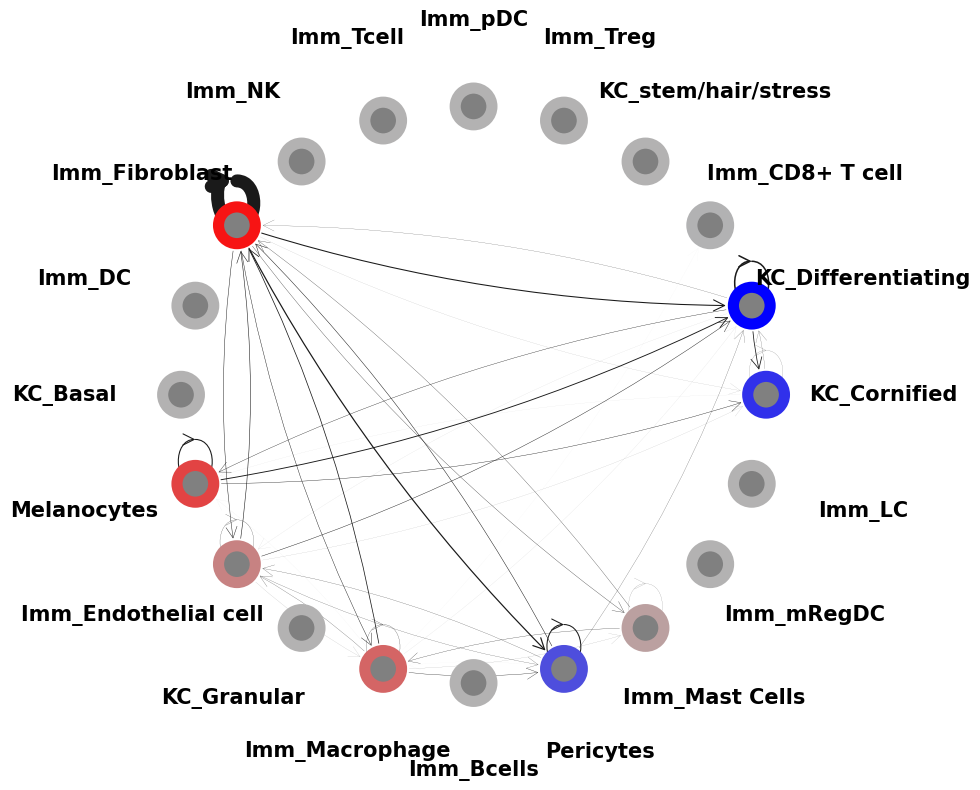

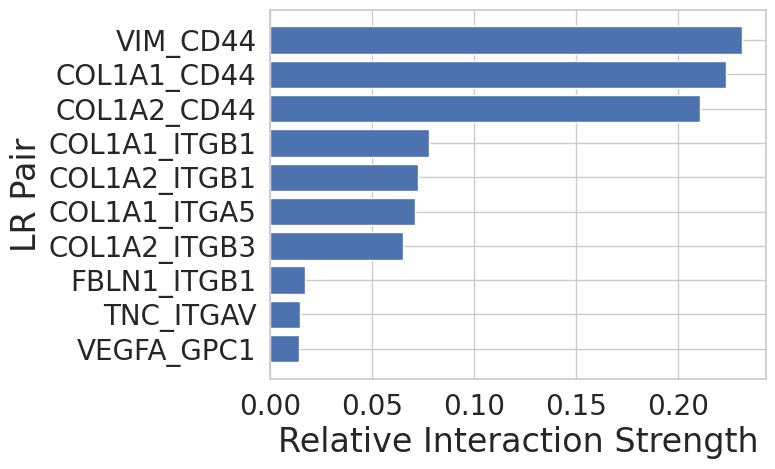

In [72]:
grouped = mmcci.an.pathway_subset(visium['lr_scores'], results, ["Epithelial Mesenchymal Transition"], strict=True)
grouped_overall = mmcci.it.calculate_overall_interactions(grouped)
mmcci.plt.network_plot(grouped_overall, remove_unconnected=False)
mmcci.plt.lr_barplot(grouped, n=10)

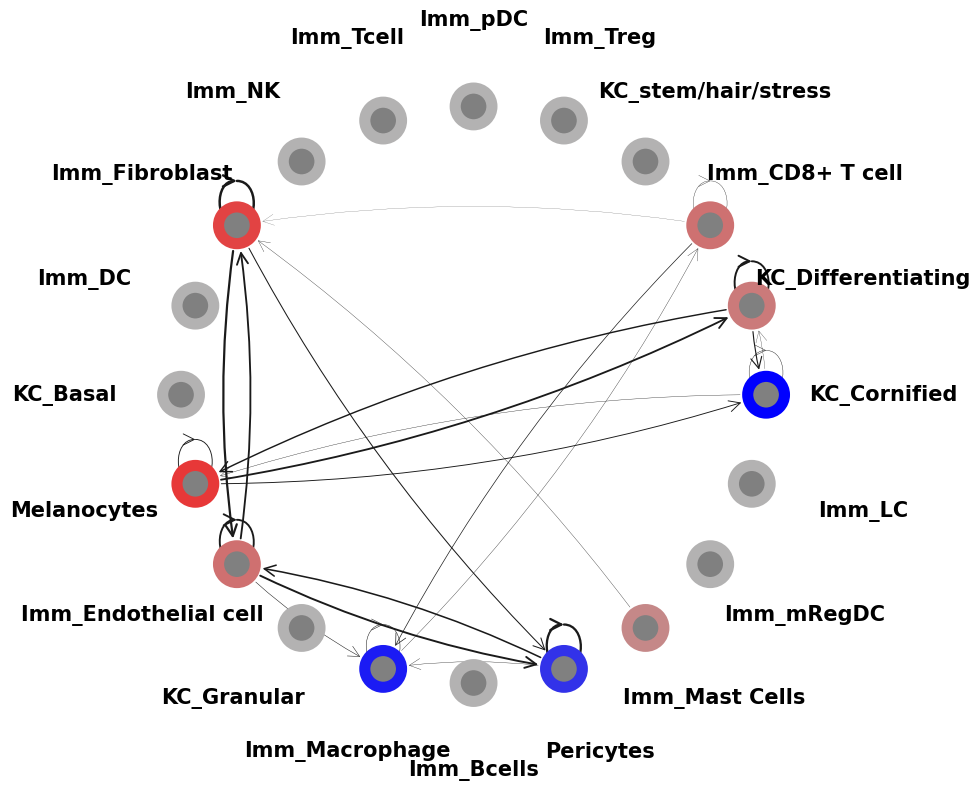

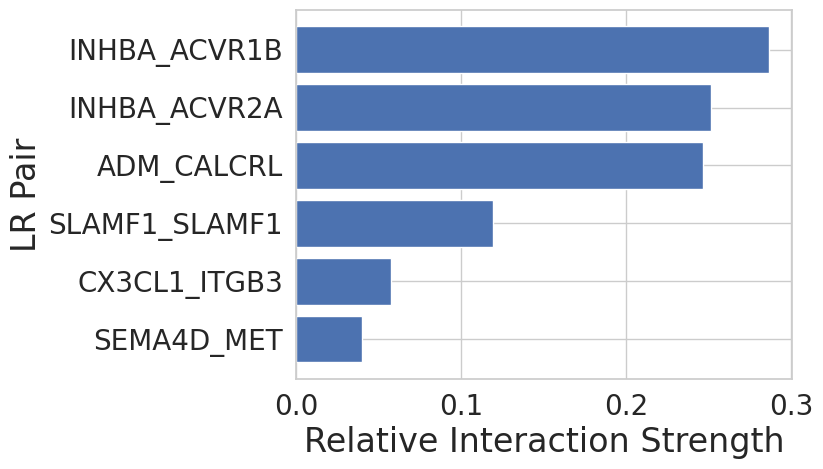

In [73]:
grouped = mmcci.an.pathway_subset(visium['lr_scores'], results, ["Inflammatory Response"], strict=True)
grouped_overall = mmcci.it.calculate_overall_interactions(grouped)
mmcci.plt.network_plot(grouped_overall, remove_unconnected=False)
mmcci.plt.lr_barplot(grouped, n=10)

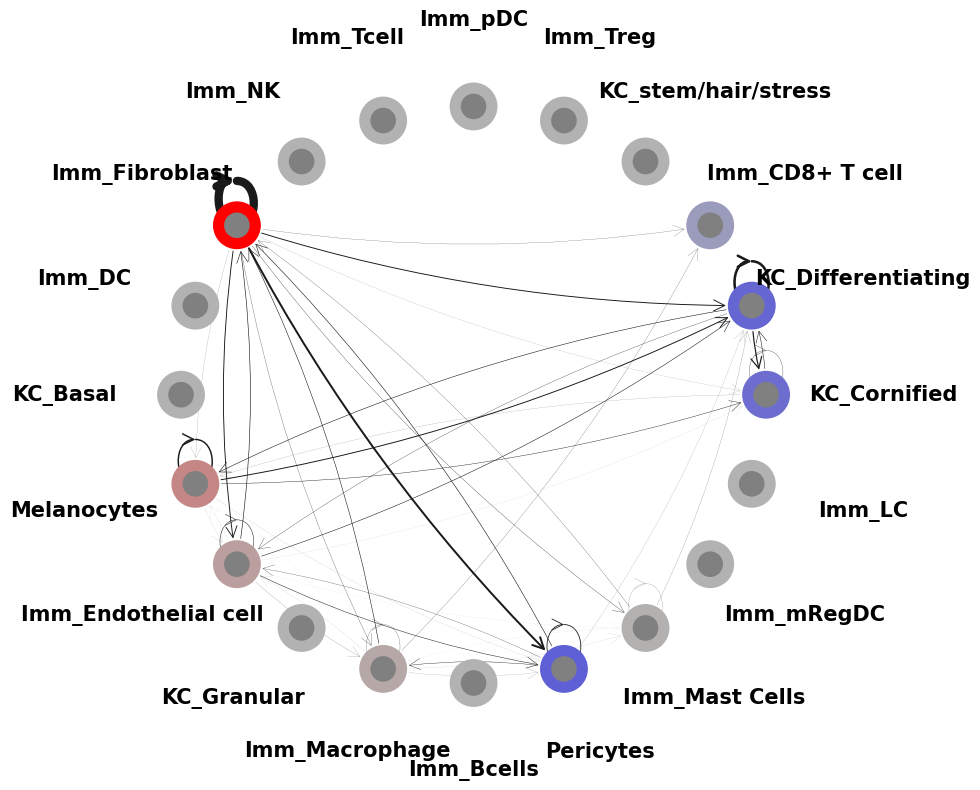

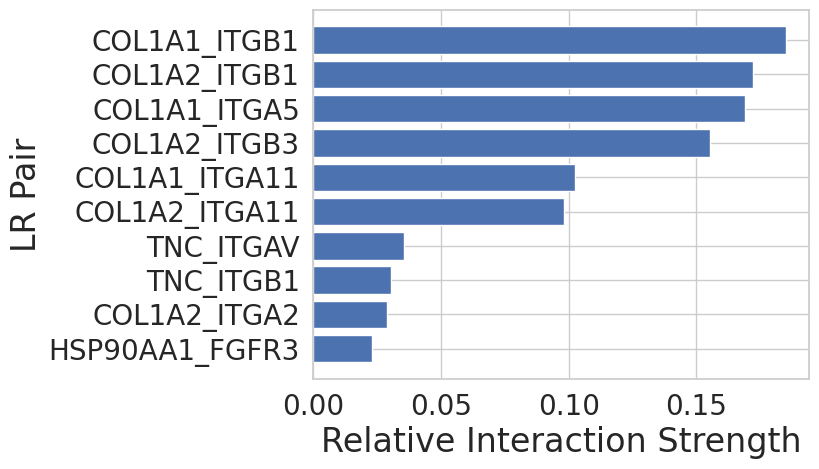

In [74]:
grouped = mmcci.an.pathway_subset(visium['lr_scores'], results, ["PI3K-Akt signaling pathway"], strict=True)
grouped_overall = mmcci.it.calculate_overall_interactions(grouped)
mmcci.plt.network_plot(grouped_overall, remove_unconnected=False)
mmcci.plt.lr_barplot(grouped, n=10)

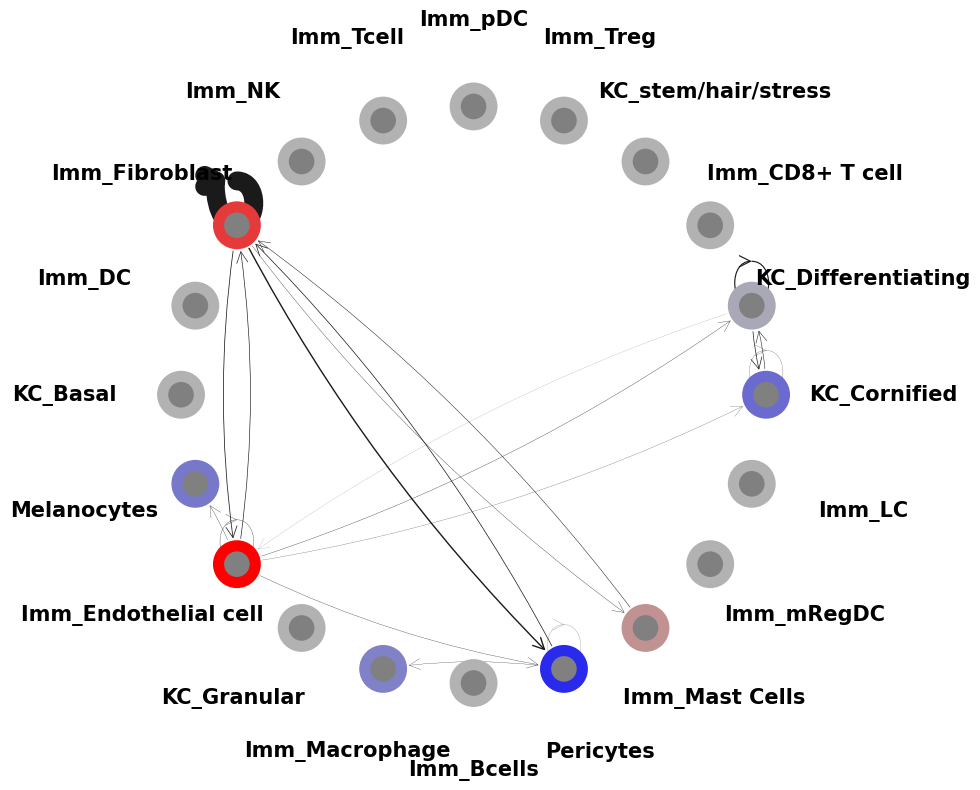

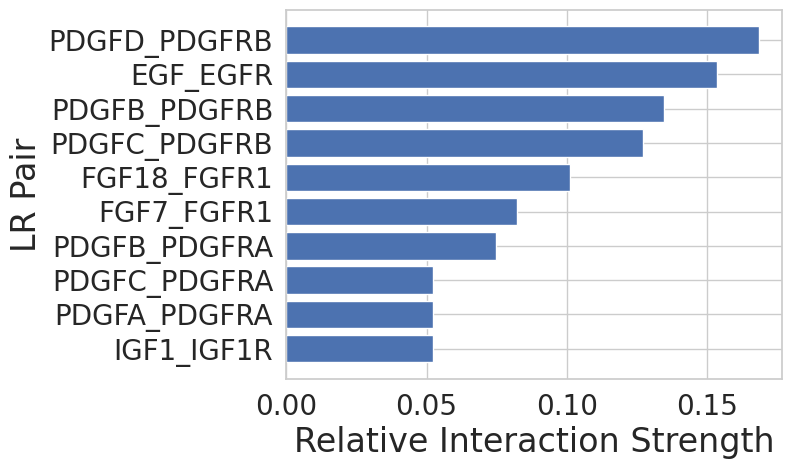

In [77]:
grouped = mmcci.an.pathway_subset(visium['lr_scores'], results, ["Melanoma"], strict=True)
grouped_overall = mmcci.it.calculate_overall_interactions(grouped)
mmcci.plt.network_plot(grouped_overall, remove_unconnected=False)
mmcci.plt.lr_barplot(grouped, n=10)